# Model fitting with active inference on a multi-agent agency learning task
Authors: Riddhi J. Pitliya & Dimitrije Markovic; July 2024


### Agency Task Description
A free-operant paradigm assesses participants' perception of agency for themselves and a simulated agent.

#### Task Structure
- Participants freely press or do not press a button.
- Simulated agent presses the button randomly 50% of the time (unknown to participants).
- Outcomes (filled or outlined shape) appear based on actions.
- Participants are told to maximise filled shape occurrences while learning action-outcome contingencies for both agents.
- 24 trials per block; participants rate perceived control after each block.

#### Key Elements
1. **Actions**: Button press/no press for both agents.
2. **Outcomes**: Filled shape (present) or outline (absent).
3. **Ratings**: Perceived control scale from -10 to 10.

#### Conditions
Five experimental conditions:
1. **Zero**: Neither agent has control.
2. **Self Positive (SP)**: Participant has positive control.
3. **Self Negative (SN)**: Participant has negative control.
4. **Other Positive (OP)**: Simulated agent has positive control.
5. **Other Negative (ON)**: Simulated agent has negative control.

*Notes: Positive control means that pressing the button predicts the presence of the outcome, and not pressing the button predicts the absence of the outcome. Negative control means that not pressing the button predicts the presence of the outcome, and pressing the button predicts the absence of the outcome. Control is deterministic (100%) when present. When one agent has control, the other has none.*

#### Data Collected
- Participants' actions
- Perceived control ratings (self and other)

#### Implementation
- Delivered via Gorilla platform (Anwyl-Irvine et al., 2020).
- 80 participants from UK and Italy.
- Groups: clinically depressed (in-patient units) and non-clinically depressed.
- BDI-II scores collected for all participants.

This active inference model simulates the task environment and agent behaviour, enabling the study of agency perception and learning.

In [1]:
%load_ext jupyter_black
%matplotlib inline

In [2]:
import os

# gpu configuration; cpu users can ignore or comment out these lines
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# some configurations
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [3]:
import numpyro

numpyro.set_platform("cpu")  # set as gpu if you're using a gpu. I'm using cpu on a mac.

/Users/riddhi/Library/CloudStorage/OneDrive-Nexus365/Oxford/Research Projects/Ox_AgencyParadox/1_Data&Analysis/jax_aifagent/pybefit/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# importing libraries. Use python 3.11 or above.
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd

import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

from jax import nn, config
from functools import partial

from pymdp.jax.agent import Agent as AIFAgent

from pybefit.inference import (
    run_svi,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import (
    Normal,
    NormalPosterior,
    NormalGamma,
    NormalGammaPosterior,
    RegularisedHorseshoe,
    RegularisedHorseshoePosterior,
)
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood

from numpyro.infer import Predictive
import numpyro.distributions as dist

from pymdp.jax.task import PyMDPEnv

seed_key = jr.PRNGKey(101)
config.update("jax_default_matmul_precision", "float32")

## Setting up the generative process

In [5]:
# defining and labelling state factors and observational modalities

agency_names = [
    "sP_oP",  # self positive, other positive
    "sP_oN",  # self positive, other negative
    "sN_oP",  # self negative, other positive
    "sN_oN",  # self negative, other negative
]

self_action_names = ["self_buttonnotpress", "self_buttonpress"]
other_action_names = ["other_buttonnotpress", "other_buttonpress"]

# defining number of state factors and states
num_states = [len(agency_names), len(self_action_names), len(other_action_names)]
num_factors = len(num_states)

# defining controllable state factors
choice_agency_names = ["no_changes"]
choice_self_action_names = ["self_notpressbutton", "self_pressbutton"]
choice_other_action_names = ["equal_distribution"]

# defining number of controllable states
num_controls = [
    len(choice_agency_names),
    len(choice_self_action_names),
    len(choice_other_action_names),
]

# defining observational modalities
obs_outcome_names = ["outcome_absent", "outcome_present"]
obs_choice_self_names = ["self_buttonnotpress", "self_buttonpress"]
obs_choice_other_names = ["other_buttonnotpress", "other_buttonpress"]

# defining number of observational modalities and observations
num_obs = [
    len(obs_outcome_names),
    len(obs_choice_self_names),
    len(obs_choice_other_names),
]
num_modalities = len(num_obs)

# defining batch size
batch_size = 80  # number of subjects
num_blocks = 15  # number of blocks
num_timesteps = 24  # number of timesteps in each block

In [6]:
num_exp_conditions = 5  # number of experimental conditions


# defining the agency task - the generative process of the task
def make_agency_task(p_outcome_env=1.0, p_other_action_env=0.5):

    # creating the likelihood matrices for the outcome modality
    a1 = jnp.array([1 - p_outcome_env, p_outcome_env])  # [0, 1]
    a2 = 1 - a1  # [1, 0]
    a3 = jnp.array([0.5, 0.5])  # [0.5, 0.5]

    # the five elements in the vectors below are for the following experimental conditions:
    # 1. self positive, other zero
    # 2. self negative, other zero
    # 3. self zero, other positive
    # 4. self zero, other negative
    # 5. self zero, other zero
    A1 = jnp.stack([a1, a2, a1, a2, a3], -1)  # self pressing, other pressing
    A2 = jnp.stack([a1, a2, a2, a1, a3], -1)  # self pressing, other not pressing
    A3 = jnp.stack([a2, a1, a1, a2, a3], -1)  # self not pressing, other pressing
    A4 = jnp.stack([a2, a1, a2, a1, a3], -1)  # self not pressing, other not pressing
    _A = jnp.stack([A4, A3, A2, A1], -1).reshape(2, 5, 2, 2)

    # creating identity likelihood matrices for proprioception and seeing exactly the other agent's actions
    a = jnp.eye(2)

    A = [
        jnp.broadcast_to(_A, (batch_size,) + _A.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
    ]  # broadcasting the likelihood matrices to the batch size

    # creating a deterministic transition matrix for the actions - i.e., action 0: always transitions to state 0 and action 1: always transitions to state 1
    B2 = jnp.stack([jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1)
    B = [
        jnp.broadcast_to(
            jnp.eye(num_exp_conditions)[..., None],
            (batch_size, num_exp_conditions, num_exp_conditions, 1),
        ),
        jnp.broadcast_to(B2, (batch_size, 2, 2, 2)),
        jnp.broadcast_to(
            jnp.ones((num_states[-1], num_states[-1], 1)) / num_states[-1],
            (batch_size, num_states[-1], num_states[-1], 1),
        ),
    ]  # broadcasting the transition matrices to the batch size

    # creating flat priors
    D = [
        jnp.ones((batch_size, 5)) / 5,
        jnp.ones((batch_size, num_states[1])) / num_states[1],
        jnp.ones((batch_size, num_states[2])) / num_states[2],
    ]  #  broadcasting priors to the batch size

    # defining the dependencies of the factors, e.g., the first modality of A depends on states 0, 1, 2, the second depends on state 1 only, etc.
    dependencies = {"A": [[0, 1, 2], [1], [2]], "B": [[0], [1], [2]]}

    params = {"A": A, "B": B, "D": D}  # creating the parameters of the task

    return PyMDPEnv(params, dependencies=dependencies)

agency_task = make_agency_task() # creating an instance of the agency task

# split the random key for reproducibility, ensuring we can generate multiple independent random streams
key, _key = jr.split(seed_key)

# reset the agency task with a new random key, initialising the task with a random starting state - using a specific key ensures reproducibility across runs
agency_task = agency_task.reset(_key)

In [7]:
# generating random keys for each agent and one extra for future use
keys = jr.split(key, batch_size + 1)
key = keys[-1]  # storing the last key for future use

# initialising actions for all agents, where all agents start with the action [0, 0, 0]
actions = jnp.broadcast_to(jnp.array([0, 0, 0]), (batch_size, 3))

# performing one step in the environment for all agents, generating observations based on the actions
obs, agency_task = agency_task.step(keys[:batch_size], actions)

## Setting up the generative model of the focal agent (participant)

In [8]:
#  defining a function to broadcast an input according to the batch size - this is useful for preparing data structures for batch processing, ensuring that each element in the pytree has a leading dimension that matches the batch size.
def broadcast_to_batch(xs, batch_size):
    return jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), xs)

# defining the likelihood (A) tensors - one for each observation modality; free parameter of p_outcome_mean (and p_outcome_scale if A learning is turned on)
def create_A(batch_size, p_outcome_mean, p_outcome_scale):

    # defining a learnable likelihood (pA) tensor for the outcome modality 
    
    ### p_outcome_mean represents the average probability of the outcome
    ### p_outcome_scale acts as a concentration parameter, affecting the certainty of the probability - higher scale values lead to more concentrated (certain) probabilities
    alpha2 = jnp.broadcast_to(p_outcome_scale * p_outcome_mean, (batch_size,)) # alpha2 is the probability of the outcome occurring
    alpha1 = jnp.broadcast_to(
        p_outcome_scale * (1 - p_outcome_mean), (batch_size,)
    ) # alpha1 is the probability of the outcome not occurring
    p_outcome_scale = jnp.expand_dims(p_outcome_scale, -1)

    # creating intermediate vectors to use to define the likelihood matrix
    a1 = jnp.stack([alpha1, alpha2], -1) # a1 = [outcome not occurring (alpha1), outcome occurring (alpha2)]
    a = jnp.ones_like(a1) * p_outcome_scale / 2 # a is a uniform probability distribution scaled by p_outcome_scale

    # constructing likelihood matrices for different action combinations; note that p_outcome_scale - a1 is just flipping a1 to create [alpha2, alpha1]
    # the four elements in the vectors below are correspond to the four states in the first state factor: SPOP, SPON, SNOP, SNON
    A1 = jnp.stack([p_outcome_scale - a1, a, a, a1], -1) # self_notpress, other_notpress
    A2 = jnp.stack([a, p_outcome_scale - a1, a1, a], -1) # self_notpress, other_press
    A3 = jnp.stack([a, a1, p_outcome_scale - a1, a], -1) # self_press, other_notpress
    A4 = jnp.stack([a1, a, a, p_outcome_scale - a1], -1) # self_press, other_press

    # combining all action combinations into a single tensor
    _pA = jnp.stack([A1, A2, A3, A4], -1).reshape(batch_size, 2, 4, 2, 2)

    null_pA = 1e4 * jnp.ones_like(_pA[..., :1, :])
    pA_outcome = jnp.concatenate([null_pA, _pA], -2) 

    # defining likelihood tensor for proprioception
    A_self_action = jnp.concatenate(
        [jnp.ones((2, 1)) / 2, jnp.eye(2)], -1
    ) # with null state shape = (2, 3)  

    # defining likelihood tensor for observing other agent's actions
    tmp = jnp.broadcast_to(jnp.expand_dims(jnp.eye(2), -2), (2, 2, 2))
    A_other_action = jnp.concatenate(
        [jnp.ones((2, 1, 2)) / 2, tmp], -2
    ) # with null state shape = (2, 3, 2)

    # combining all likelihood tensors into a single tensor 
    A = [pA_outcome / pA_outcome.sum(1, keepdims=True)] + broadcast_to_batch(
        [A_self_action, A_other_action], batch_size
    )
    A_factor_list = [[0, 1, 2], [1], [1, 2]] # defining the dependencies of the factors, e.g., the first modality of A depends on states 0, 1, 2, the second depends on state 1 only, etc.

    # making dirichlet prior for the likelihood matrices
    pA = [pA_outcome] + [None] * len(A[1:])

    return A, A_factor_list, pA


A, A_list, pA = create_A(batch_size, 0.7, 1.0)

In [9]:
# adding a null state for self action for timestep 0 to make all observations uninformative
num_states = [
    4,
    3,
    2,
]

# defining the transition (B) tensors; no free parameters here
def create_B(batch_size):
    
    # transition matrix for agency context (SPOP, SPON, SNOP, SNON) - it does not change across timesteps
    d = len(agency_names)
    B_context = jnp.expand_dims(jnp.eye(d), -1)

    # transition matrix for self action (self_notpressbutton, self_pressbutton) - fully controllable by the focal agent 
    B_self_choice = jnp.stack(
        [jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1
    )

    B_self_choice = jnp.pad(
        B_self_choice, ((1, 0), (0, 0), (0, 0))
    )  # with null state shape = (3, 3, 2)

    B_self_choice = jnp.concatenate([B_self_choice[:, :1, :], B_self_choice], axis=1)

    ### B matrix for actions the other can make
    d1, p1 = len(other_action_names), len(choice_other_action_names)
    B_other_choice = jnp.ones((d1, d1, p1)) / d1

    B = broadcast_to_batch([B_context, B_self_choice, B_other_choice], batch_size)
    dependencies = [[0], [1], [2]]

    return B, dependencies

# defining the preference (C) tensor - we have a free parameter for preference over outcome being present (outcomepref)
def create_C(batch_size, outcomepref):
    C1 = jnp.pad(outcomepref[..., None], ((0, 0), (1, 0)))
    C2 = jnp.zeros((batch_size, 2))
    C3 = jnp.zeros((batch_size, 2))

    return [C1, C2, C3]

# defining the prior (D) tensor - we have a free parameter for the priors over the agency context (logits). These are three free parameters as the fourth can be inferred from the other three.
def create_D(batch_size, logits):
    D_context = nn.softmax(jnp.pad(logits, [(0, 0), (0, 1)]), -1)
    # D_context = jnp.array([0.25, 0.25, 0.25, 0.25])
    D_self_action = jnp.array([1.0, 0.0, 0.0])
    D_other_action = jnp.ones(num_states[-1]) / num_states[-1]

    return [
        D_context,
    ] + broadcast_to_batch([D_self_action, D_other_action], batch_size)


# defining the habit (E) tensor - we have a free parameter for habit of press the button (habit_press)
def create_E(batch_size, habit_press):
    log_E = jnp.pad(habit_press[..., None], ((0, 0), (1, 0)))
    return nn.softmax(log_E, -1)

## Defining some functions for the model fitting process

In [10]:
# function for computing the auxiliary likelihood for self and other ratings based on the agent's beliefs about agency - used to fit the model to the data, specifically the ratings
def auxiliary_likelihood(z, agent, data, input, *args):
    batch_size = agent.batch_size
    assert batch_size == len(z)

    # computing scales for self and other ratings to determine the uncertainty in the ratings
    scale_self = numpyro.deterministic("scale_self", jnp.exp(-2 + 0.5 * z[..., 0]))
    scale_other = numpyro.deterministic("scale_other", jnp.exp(-2 + 0.5 * z[..., 1]))

    scale_self = jnp.expand_dims(scale_self, -1)
    scale_other = jnp.expand_dims(scale_other, -1)

    # handling observed data if available
    if data is not None:
        obs_self, obs_other = data["auxiliary_actions"]
        # creating a mask to only consider the last rating
        mask = jnp.zeros_like(obs_self, dtype=jnp.bool)
        mask = mask.at[..., -1].set(True)
    else:
        obs_self = None
        obs_other = None
        mask = True

    # extracting beliefs about agency from the input
    beliefs_agency = input["beliefs"][0][..., 1:, :]

    # computing mean ratings for self and other based on beliefs; ratings are in the range [-1, 1]
    mu_self = (beliefs_agency[..., 0] + beliefs_agency[..., 1]) - (
        beliefs_agency[..., 2] + beliefs_agency[..., 3]
    ) 

    mu_other = (beliefs_agency[..., 0] + beliefs_agency[..., 2]) - (
        beliefs_agency[..., 1] + beliefs_agency[..., 3]
    ) 

    # sampling from normal distributions for self and other ratings to compute the likelihood of observed ratings
    numpyro.sample(
        "aux_self",
        dist.Normal(mu_self, scale_self).mask(mask),
        obs=obs_self,
    )
    numpyro.sample(
        "aux_other",
        dist.Normal(mu_other, scale_other).mask(mask),
        obs=obs_other,
    )

In [11]:
# function for transforming z (random unconstrained parameters for each agent) into model parameters
def transform(z):
    num_agents, np = z.shape
    assert np == 9  # ensures exactly 9 parameters are present

    # setting the first four parameters in z to model parameters
    ### note that numpyro.deterministic creates a named, traceable deterministic node in the probabilistic model, allowing us to keep track of the parameters
    p_outcome_mean = numpyro.deterministic("expected_outcome", 0.5 + nn.sigmoid(z[..., 0]) / 2) # defines the prior/expected probability of outcome, ranging from 0.5 to 1 (centered around 0.75)
    p_outcome_scale = 1.0  # sets prior scale of learnable tensor (not a free parameter)
    outcomepref = numpyro.deterministic("outcome_pref", z[..., 1]) 
    habit_press = z[..., 2] 
    gamma = numpyro.deterministic("gamma", nn.softplus(1.0 + z[..., 3]))

    # specifying the model parameters in the generative model, including fifth to seventh parameters in z
    A, A_dependencies, pA = create_A(num_agents, p_outcome_mean, p_outcome_scale)
    numpyro.deterministic("A", A)
    B, B_dependencies = create_B(num_agents)
    C = create_C(num_agents, outcomepref)
    D = create_D(num_agents, z[..., 4:7])
    numpyro.deterministic("D", D)
    E = create_E(num_agents, habit_press)
    numpyro.deterministic("E", E)

    pB = None

    # initialises the active inference agent
    agents = AIFAgent(
        A, B, C, D, E, pA, pB,
        A_dependencies=A_dependencies,
        B_dependencies=B_dependencies,
        use_param_info_gain=False,
        use_utility=True,
        use_states_info_gain=True,
        inference_algo="fpi",
        learn_A=False, # set as True if we want to learn the likelihood tensor for the outcome modality 
        learn_B=False,
        learn_D=False,
        num_iter=4,
        alpha=1.0,
        gamma=gamma,
        action_selection="stochastic",
    )
    return agents, partial(auxiliary_likelihood, z[..., -2:]) # returns the agents and the auxiliary likelihood function where the last two parameters from z are already supplied, leaving the other parameters to be filled in later when the function is called

# sets up parameters and initialises agents
num_params = 9
num_agents = batch_size
key, _key = jr.split(seed_key)
z = jr.normal(_key, shape=(num_agents, num_params))

agents, aux_like = transform(z)

## Testing to see if the model works. 
Not model fitting yet. 

In [12]:
# defines task options for the model
opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
    "record_agent": True,  # enables recording of agent states in the samples
}
# sets up model options including task options
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

# initialises prior distribution for model parameters
prior = Normal(num_params, num_agents, backend="numpyro")
# creates numpyro model with specified prior, transform, and likelihood
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

# sets up predictive distribution for the model
pred = Predictive(model, num_samples=1)
# generates new random key for reproducibility
key, _key = jr.split(key)
# generates samples from the predictive distribution
samples = pred(_key)

2024-08-27 21:50:03.050511: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-27 21:55:04.305489: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 7m1.257225s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [74]:
print(samples.keys()) # you can print out any of these keys to see what the samples contain

dict_keys(['A', 'D', 'E', 'agent_sequence', 'aux_other', 'aux_self', 'beliefs', 'expected_outcome', 'gamma', 'init_agent', 'multiaction_cat', 'multiaction_probs', 'multiactions', 'outcome_pref', 'outcomes', 'scale_other', 'scale_self', 'states', 'z'])


Plotting agent's beliefs about agency under different experimental conditions.

s_zer_o_zer


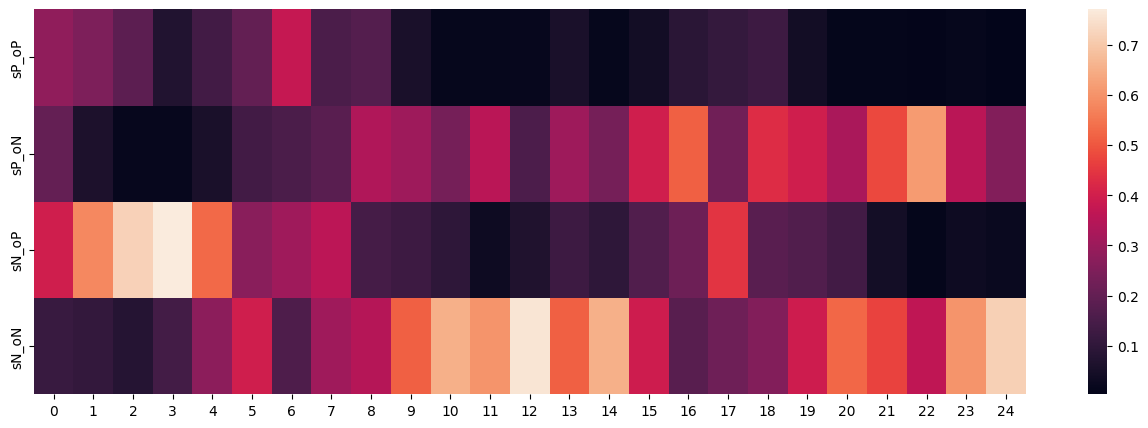

In [72]:
labels = {
    0: "s_pos_o_zer",
    1: "s_neg_o_zer",
    2: "s_zer_o_pos",
    3: "s_zer_o_neg",
    4: "s_zer_o_zer",
}

n_block = 0
n_subject = 0

plt.figure(figsize=(16, 5))
sns.heatmap(samples["beliefs"][0][0][n_block, n_subject].T)
plt.yticks([0.5, 1.5, 2.5, 3.5], labels=agency_names)

exp_condition = samples["states"][-1][0][1]

print(labels[exp_condition[n_block, n_subject].item()])

s_pos_o_zer


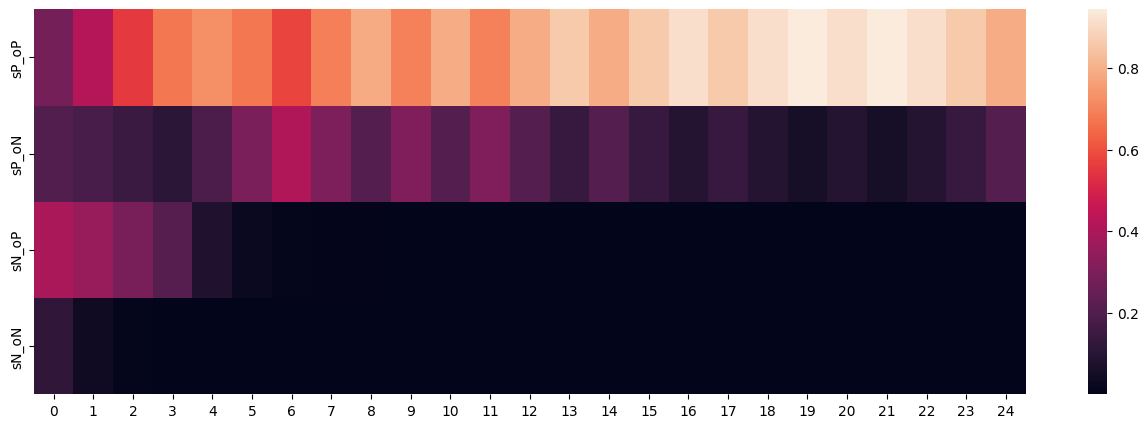

In [73]:
n_block = 1
n_subject = 0

plt.figure(figsize=(16, 5))
sns.heatmap(samples["beliefs"][0][0][n_block, n_subject].T)
plt.yticks([0.5, 1.5, 2.5, 3.5], labels=agency_names)

exp_condition = samples["states"][-1][0][1]

print(labels[exp_condition[n_block, n_subject].item()])

Creating a plot comparing ratings estimated from final beliefs with ratings sampled from the model's auxiliary likelihood. This comparison ensures consistency between belief-based estimates and model-generated samples across experimental conditions


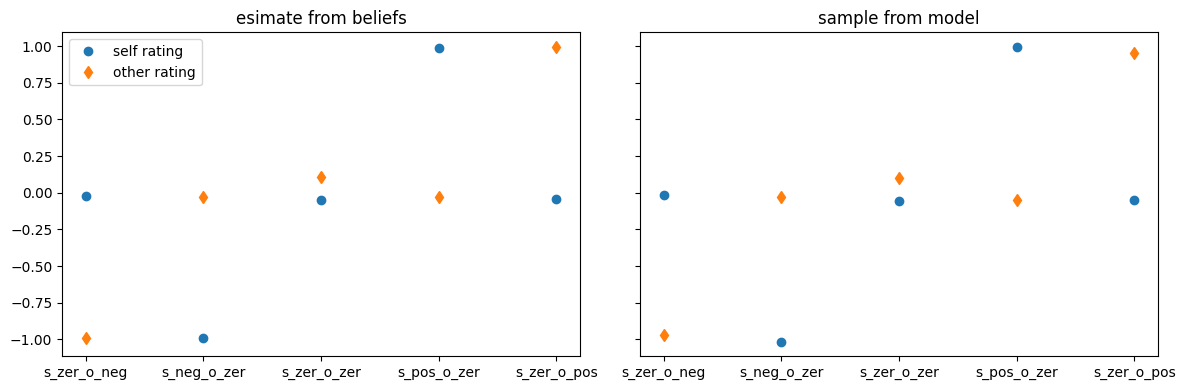

In [16]:

# extracts experimental condition and final beliefs about conditions
exp_condition = samples["states"][-1][0][0]
last_beliefs_about_condition = samples["beliefs"][0][..., -1, :]

# calculates self-rating based on final beliefs
self_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 3]
)

# calculates other-rating based on final beliefs
other_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 3]
)

# sets up plot with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# extracts sampled ratings for self and other
smpl_other_rating = samples["aux_other"][0, ..., -1]
smpl_self_rating = samples["aux_self"][0, ..., -1]

# initialises lists for plotting data
x, y1, y2, smpl_y1, smpl_y2 = [], [], [], [], []

# calculates mean ratings for each condition
for i in [3, 1, 4, 0, 2]:
    loc = exp_condition == i
    x.append(labels[i])
    y1.append(self_rating[loc].mean())
    y2.append(other_rating[loc].mean())
    smpl_y1.append(smpl_self_rating[loc].mean())
    smpl_y2.append(smpl_other_rating[loc].mean())

# plots ratings estimated from beliefs
axes[0].plot(x, y1, "o", label="self rating")
axes[0].plot(x, y2, "d", label="other rating")

# plots ratings sampled from model
axes[1].plot(x, smpl_y1, "o", label="self rating")
axes[1].plot(x, smpl_y2, "d", label="other rating")

# sets titles and legend
axes[0].set_title("estimate from beliefs")
axes[1].set_title("sample from model")
axes[0].legend()

# adjusts layout
fig.tight_layout()

## Parameter recovery with simulated behaviour

This section demonstrates the recoverability of the model parameters through a simulation study. The process involves:

1. Simulating behaviour using the parametric generative model of active inference agents (i.e., creating fake data)
2. Inverting the model using these simulated responses (i.e., fitting the model with unknown parameters to the fake data to estimate the parameters)
3. Comparing the recovered parameters to the true values used in simulation (i.e., checking how close the fitted model parameters are to the true parameters used to simulate the fake data)    

We show that all 9 parameters of the model are recoverable. This is evidenced by the estimated means of the recovered parameters closely aligning with their true values across different simulations.

This parameter recovery analysis ensures that the model can capture the underlying processes generating the observed behaviour.

{'seed': 101, 'enumerate': False, 'iter_steps': 1000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


  0%|          | 0/1000 [00:00<?, ?it/s]2024-08-27 22:00:51.936291: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m26.90162s

********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 1000/1000 [24:02<00:00,  1.44s/it, init loss: 46022.7812, avg. loss [951-1000]: 16918.6562]


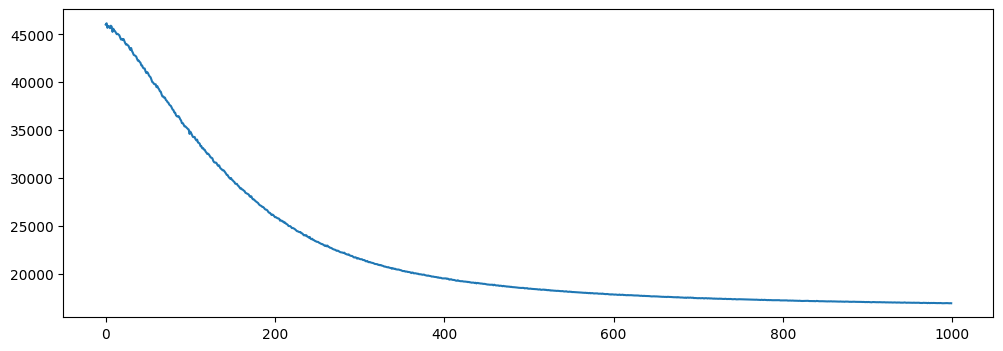

In [17]:
# creating a dictionary of measurements from the samples
measurements = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
    "auxiliary_actions": [
        samples["aux_self"][0],
        samples["aux_other"][0],
    ],
}

# initialising the model with prior, transform, likelihood, and model options specified earlier
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)
# set up the variational posterior
posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# setting options for stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1000, "seed": 101}
print(opts_svi)

# performing inference using stochastic variational inference
svi_samples, svi, results = run_svi(model, posterior, measurements, opts=opts_svi)
# plotting the loss over iterations - it should be decreasing
plt.figure(figsize=(12, 4))
plt.plot(results.losses)

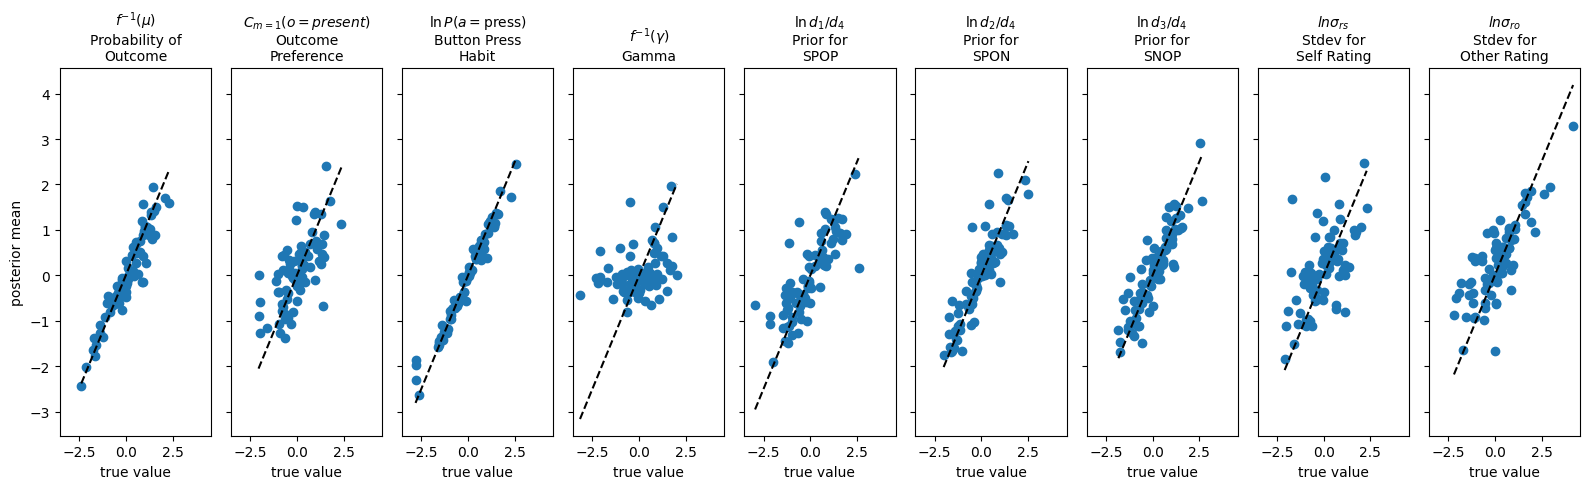

In [75]:
# plotting the true and recovered parameters - they should be approximiately lining up with the dotted line
param_label = [
    (r"$f^{-1}(\mu)$", "Probability of\nOutcome"),
    (r"$C_{m=1}(o=present)$", "Outcome\nPreference"),
    (r"$\ln P(a=\text{press})$", "Button Press\nHabit"),
    (r"$f^{-1}(\gamma)$", "Gamma"),
    (r"$\ln d_1/d_4$", "Prior for\nSPOP"),
    (r"$\ln d_2/d_4$", "Prior for\nSPON"),
    (r"$\ln d_3/d_4$", "Prior for\nSNOP"),
    (r"$ln \sigma_{rs}$", "Stdev for\nSelf Rating"),
    (r"$ln \sigma_{ro}$", "Stdev for\nOther Rating"),
]
z = samples["z"][0]
fig, axes = plt.subplots(1, z.shape[-1], figsize=(16, 5), sharex=True, sharey=True)

for i in range(z.shape[-1]):
    axes[i].scatter(z[:, i], svi_samples["z"].mean(0)[:, i], label=i)
    axes[i].plot((z[:, i].min(), z[:, i].max()), (z[:, i].min(), z[:, i].max()), "k--")
    axes[i].set_xlabel("true value")
    axes[i].set_title(param_label[i][0] + "\n" + param_label[i][1], fontsize=10)

axes[0].set_ylabel("posterior mean")
fig.tight_layout()

## Fitting behavioural data

Now we fit the behavioural data. We will first fit it for all data points, and then we will fit it for each group (depressed and non-depressed) separately.     

In [19]:
# reading the behavioural data  
exp_data = pd.read_csv("behavioural_data_agency.csv")

# creating empty lists to store the data
outcomes = [[], [], []]
multiactions = []
ratings = [[], []]
group = []

# looping through each participant and wrangling the dataset for each participant
for pid in exp_data.PID.unique():
    df = exp_data.loc[exp_data.PID == pid].pivot(
        index=["block_num"],
        columns=["timesteps"],
        values=[
            "outcome",
            "action_self",
            "action_other",
            "rating_self",
            "rating_other",
        ],
    )
    group.append(exp_data.loc[exp_data.PID == pid].depgroup.unique().item())
    outcomes[0].append(jnp.array(df.outcome.values))
    outcomes[1].append(jnp.array(df.action_self.values))
    outcomes[2].append(jnp.array(df.action_other.values))

    ratings[0].append(jnp.array(df.rating_self.values))
    ratings[1].append(jnp.array(df.rating_other.values))

    # check for any NaN values in outcomes
    for o in outcomes:
        if jnp.any(jnp.isnan(o[-1])):
            print(pid)

    multiactions.append(outcomes[1][-1])

# creating a boolean array for depression group: false for non-depressed, true for depressed
dep_group = jnp.array([False if g == "nondep" else True for g in group])

# stackking up the observation modalities as multiactions
outcomes = [jnp.pad(jnp.stack(o, 1), [(0, 0), (0, 0), (1, 0)]) for o in outcomes]
multiactions = jnp.pad(
    jnp.stack(multiactions, 1)[..., None], [(0, 0), (0, 0), (0, 0), (1, 1)]
)

# stacking and normalising ratings to range [-1, 1]
ratings = [jnp.stack(r, 1) / 100 for r in ratings]

# creating a dictionary of experiment measurements
exp_measurements = {
    "outcomes": outcomes,
    "multiactions": multiactions,
    "auxiliary_actions": ratings,
}

# setting up task options
opts_task = {
    "num_blocks": multiactions.shape[0],
    "num_trials": multiactions.shape[-2],
    "num_agents": multiactions.shape[1],
    "record_agent": True,
}

# setting up model options
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

In [20]:
def plot_results(samples):
    # creating a plot comparing parameter values between depressed and non-depressed groups
    fig, axes = plt.subplots(1, num_params, figsize=(16, 5), sharex=True, sharey=True)
    grp = jnp.array([0 if g == "nondep" else 1 for g in group])
    dep = grp == 1
    for i in range(num_params):
        # plot non-depressed group
        sns.stripplot(samples["z"].mean(0)[~dep, i], ax=axes[i], label="nondep")
        # plot depressed group
        sns.stripplot(samples["z"].mean(0)[dep, i], ax=axes[i], label="dep")
        # set title using both mathematical notation and descriptive term
        axes[i].set_title(param_label[i][0] + "\n" + param_label[i][1], fontsize=10)

    axes[0].legend(title="group")
    axes[0].set_ylabel("value")
    fig.tight_layout()

def plot_results2(samples):
    # creating a plot comparing transformed parameter values between depressed and non-depressed groups
    D0 = jnp.mean(samples["D"][0][..., :-1] / samples["D"][0][..., -1:], 0)

    fig, axes = plt.subplots(2, (num_params + 1) // 2, figsize=(16, 5), sharex=True)
    axes = axes.flatten()
    grp = jnp.array([0 if g == "nondep" else 1 for g in group])
    dep = grp == 1
    for i in range(num_params):
        # plot different parameters based on their type
        if param_label[i][0] == r"$f^{-1}(\mu)$":
            sns.stripplot(samples["expected_outcome"].mean(0)[~dep], ax=axes[i], label="nondep")
            sns.stripplot(samples["expected_outcome"].mean(0)[dep], ax=axes[i], label="dep")
        elif param_label[i][0] == r"$C_{m=1}(o=present)$":
            sns.stripplot(samples["outcome_pref"].mean(0)[~dep], ax=axes[i], label="nondep")
            sns.stripplot(samples["outcome_pref"].mean(0)[dep], ax=axes[i], label="dep")
        elif param_label[i][0] == r"$\ln P(a=\text{press})$":
            sns.stripplot(samples["E"].mean(0)[~dep, 1], ax=axes[i], label="nondep")
            sns.stripplot(samples["E"].mean(0)[dep, 1], ax=axes[i], label="dep")
        elif param_label[i][0] == r"$f^{-1}(\gamma)$":
            sns.stripplot(samples["gamma"].mean(0)[~dep], ax=axes[i], label="nondep")
            sns.stripplot(samples["gamma"].mean(0)[dep], ax=axes[i], label="dep")
        elif "d_4" in param_label[i][0]:
            sns.stripplot(D0[~dep, i - 4], ax=axes[i], label="nondep")
            sns.stripplot(D0[dep, i - 4], ax=axes[i], label="dep")
        elif param_label[i][0] == r"$ln \sigma_{rs}$":
            sns.stripplot(samples["scale_self"].mean(0)[0, ~dep], ax=axes[i], label="nondep")
            sns.stripplot(samples["scale_self"].mean(0)[0, dep], ax=axes[i], label="dep")
        elif param_label[i][0] == r"$ln \sigma_{ro}$":
            sns.stripplot(samples["scale_other"].mean(0)[0, ~dep], ax=axes[i], label="nondep")
            sns.stripplot(samples["scale_other"].mean(0)[0, dep], ax=axes[i], label="dep")

        axes[i].set_title(param_label[i][0] + "\n" + param_label[i][1], fontsize=10)

    axes[0].legend(title="group")
    axes[0].set_ylabel("value")
    fig.tight_layout()

Now, we fit the data using the Regularised Horseshoe prior over unconstrained parameter values. This prior is designed to balance between group-level trends and individual differences effectively. It assumes that most individuals are similar to the group average, but allows for some individuals to differ substantially. This approach helps to estimate the group-level average more accurately, especially when data from individual participants may not provide enough information for precise individual-level estimates. The prior tends to pull individual estimates towards the group average when there isn't strong evidence for individual differences, which can improve the overall reliability of the estimates.

  0%|          | 0/5000 [00:00<?, ?it/s]2024-08-27 22:25:52.714917: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m15.610617s

********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 5000/5000 [1:39:25<00:00,  1.19s/it, init loss: 45071.3750, avg. loss [4751-5000]: 18790.0273]


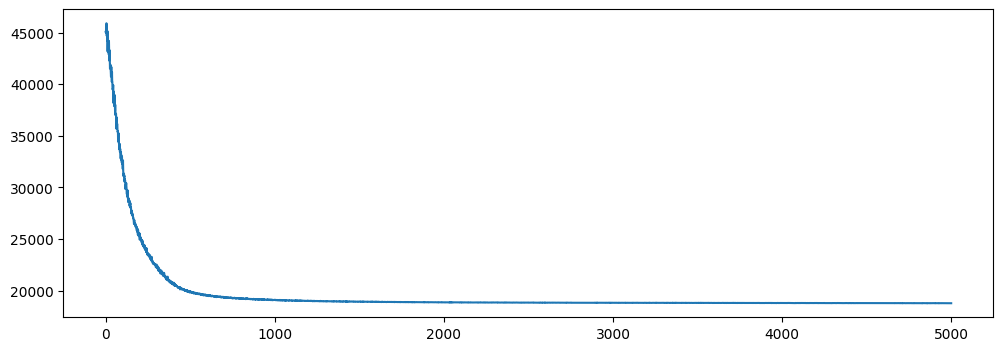

In [28]:
# defining the prior as a regularised horseshoe distribution
prior = RegularisedHorseshoe(num_params, num_agents, backend="numpyro")

# creating the model using the prior, transform, likelihood functions and the task options
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

# defining the variational posterior using the regularised horseshoe distribution
posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_agents, backend="numpyro")
)

# setting options for stochastic variational inference; number of iterations set as 5000
opts_svi = default_dict_numpyro_svi | {"iter_steps": 5000, "seed": 623342}

# performing inference using stochastic variational inference
svi_samples3, svi3, results3 = run_svi(model, posterior, exp_measurements, opts=opts_svi)

# plotting the loss over iterations - it should be decreasing
plt.figure(figsize=(12, 4))
plt.plot(results3.losses)

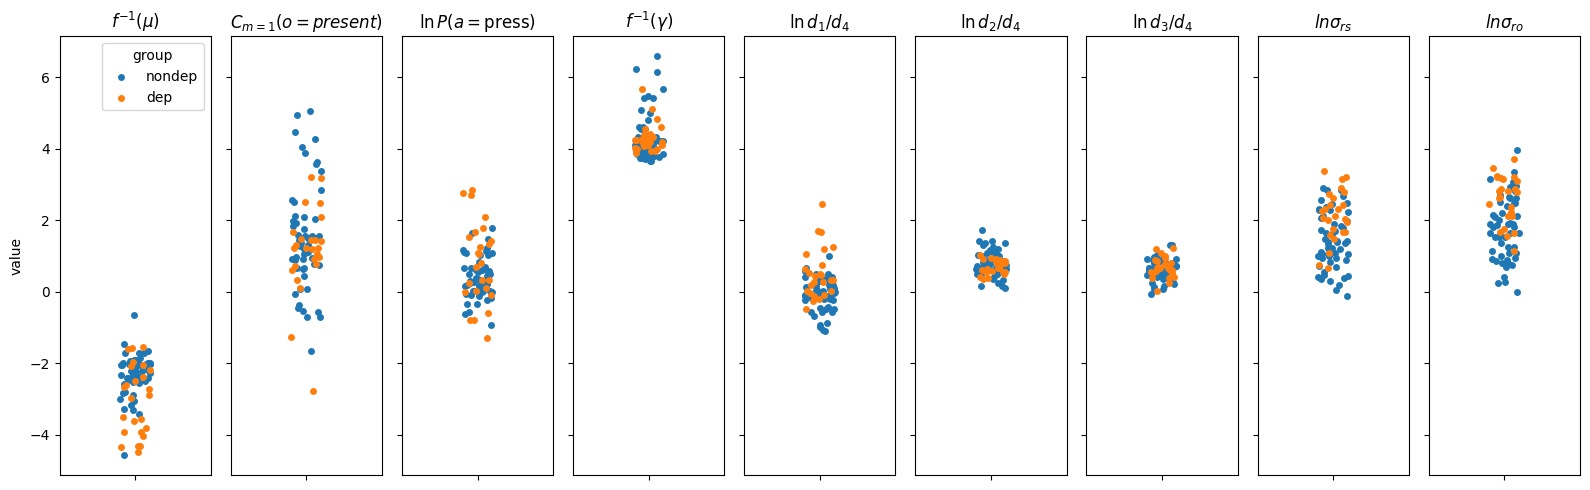

In [29]:
plot_results(svi_samples3)

In [77]:
# plot_results2(svi_samples3)

In [31]:
# simulating behaviour from posterior samples

opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
    "record_agent": True,  # setting this to true creates an 'init_agent' and 'agent_sequence' variable in samples (posterior or prior samples)
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = RegularisedHorseshoe(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, guide=posterior, params=results3.params, num_samples=1)
key, _key = jr.split(key)
post_pred_samples = pred(_key)

2024-08-28 00:03:06.860649: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-28 00:08:02.961739: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m56.110994s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [78]:
post_pred_samples.keys() # print any of these keys out to see the output

dict_keys(['A', 'D', 'E', 'agent_sequence', 'aux_other', 'aux_self', 'beliefs', 'expected_outcome', 'gamma', 'init_agent', 'multiaction_cat', 'multiaction_probs', 'multiactions', 'outcome_pref', 'outcomes', 'scale_other', 'scale_self', 'sigma', 'states', 'z'])

## Fitting behavioural data for depressed and non-depressed groups separately

#### Depressed group

  0%|          | 0/5000 [00:00<?, ?it/s]2024-08-28 00:14:16.588711: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m49.23527s

********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 5000/5000 [37:12<00:00,  2.24it/s, init loss: 17267.5137, avg. loss [4751-5000]: 5517.8145]


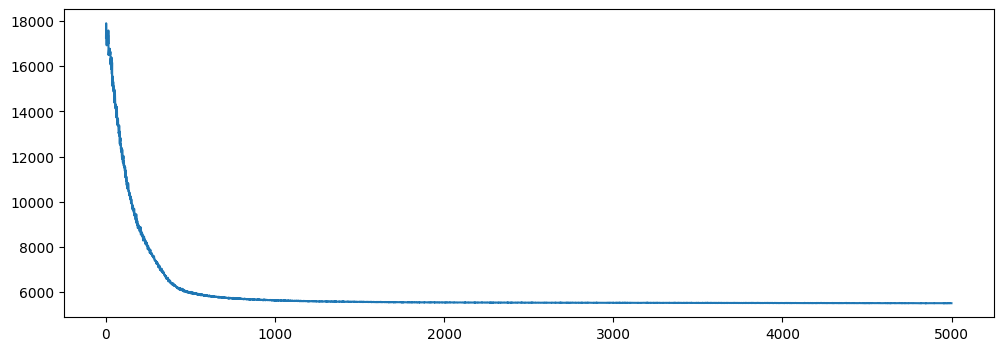

In [33]:
# filter the experimental data to include only depressed participants
dep_data = jtu.tree_map(lambda x: x[:, dep_group], exp_measurements)

# count the number of depressed participants
num_dep_agents = dep_group.sum().item()

# update the task options with the number of depressed participants
opts_task["num_agents"] = num_dep_agents
batch_size = num_dep_agents

# set up model options
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

# define the prior for the depressed group model
dep_prior = RegularisedHorseshoe(num_params, num_dep_agents, backend="numpyro")

# create the probabilistic model for the depressed group
dep_model = NumpyroModel(dep_prior, transform, likelihood, opts=opts_model)

# define the variational posterior for the depressed group model
dep_posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_dep_agents, backend="numpyro")
)

# set options for stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 5000, "seed": 6242}

# perform inference using stochastic variational inference
svi_samples_dep, svi_dep, results_dep = run_svi(
    dep_model, dep_posterior, dep_data, opts=opts_svi
)

# plot the loss over iterations
plt.figure(figsize=(12, 4))
plt.plot(results_dep.losses)

In [40]:
# simulating behaviour from posterior samples

# create a new instance of the agency task which uses the batch_size of the number of depressed participants
agency_task = make_agency_task()

# generate new random keys for reproducibility
key, _key = jr.split(seed_key)
agency_task = agency_task.reset(_key)

# set up task options for the model
opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_dep_agents,
    "record_agent": True,  
}

# set up model options including task options
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

# initialise prior distribution for model parameters
dep_prior = RegularisedHorseshoe(num_params, num_dep_agents, backend="numpyro")

# create numpyro model with specified prior, transform, and likelihood
dep_model = NumpyroModel(dep_prior, transform, likelihood, opts=opts_model)

# set up predictive distribution for the model
dep_pred = Predictive(
    dep_model, guide=dep_posterior, params=results_dep.params, num_samples=1
)

# generate new random key for reproducibility
key, _key = jr.split(key)

# generate samples from the predictive distribution
dep_post_pred_samples = dep_pred(_key)

2024-08-28 09:39:12.422566: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-28 09:45:09.615886: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 7m57.195822s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


#### Non-depressed group

  0%|          | 0/5000 [00:00<?, ?it/s]2024-08-28 09:55:03.010181: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-28 09:57:50.513611: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m47.505754s

********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 5000/5000 [1:21:09<00:00,  1.03it/s, init loss: 27894.6777, avg. loss [4751-5000]: 13282.0068]


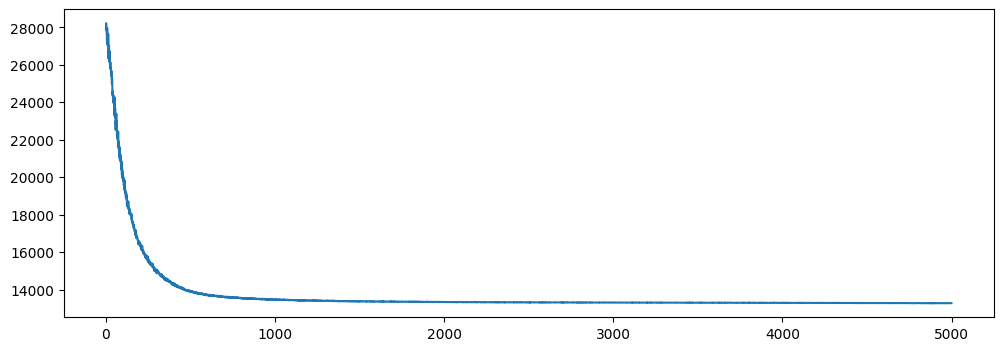

In [43]:
# filter the experimental data to include only non-depressed participants
nondep_data = jtu.tree_map(lambda x: x[:, ~dep_group], exp_measurements)

# count the number of non-depressed participants
num_nondep_agents = num_agents - dep_group.sum().item()

# update the task options with the number of non-depressed participants
opts_task["num_agents"] = num_nondep_agents
batch_size = num_nondep_agents

# set up model options
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

# define the prior for the non-depressed group model
nondep_prior = RegularisedHorseshoe(num_params, num_nondep_agents, backend="numpyro")

# create the probabilistic model for the non-depressed group
nondep_model = NumpyroModel(nondep_prior, transform, likelihood, opts=opts_model)

# define the variational posterior for the non-depressed group model
nondep_posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_nondep_agents, backend="numpyro")
)

# set options for stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 5000, "seed": 3342}

# perform inference using stochastic variational inference
svi_samples_nondep, svi_nondep, results_nondep = run_svi(
    nondep_model, nondep_posterior, nondep_data, opts=opts_svi
)

# plot the loss over iterations
plt.figure(figsize=(12, 4))
plt.plot(results_nondep.losses)

In [44]:
# simulating behaviour from posterior samples for non-depressed group

# create a new instance of the agency task using the number of non-depressed participants as batch size
agency_task = make_agency_task()

# generate new random keys for reproducibility
key, _key = jr.split(seed_key)
agency_task = agency_task.reset(_key)

# set up task options for the model
opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_nondep_agents,
    "record_agent": True,  
}

# set up model options including task options
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

# initialise prior distribution for model parameters
nondep_prior = RegularisedHorseshoe(num_params, num_nondep_agents, backend="numpyro")

# create numpyro model with specified prior, transform, and likelihood
nondep_model = NumpyroModel(nondep_prior, transform, likelihood, opts=opts_model)

# set up predictive distribution for the model
nondep_pred = Predictive(
    nondep_model, guide=nondep_posterior, params=results_nondep.params, num_samples=1
)

# generate new random key for reproducibility
key, _key = jr.split(key)

# generate samples from the predictive distribution
nondep_post_pred_samples = nondep_pred(_key)

2024-08-28 11:16:32.896821: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-28 11:21:29.990901: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m57.100488s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


#### Printing out the results of parameter estimations for depressed and non-depressed groups

In [92]:
param_label = [
    ("f^(-1)(μ)", "Probability of Outcome"),
    ("C_(m=1)(o=present)", "Outcome Preference"),
    ("ln P(a=press)", "Button Press Habit"),
    ("f^(-1)(γ)", "Gamma"),
    ("ln d_1/d_4", "Prior for SPOP"),
    ("ln d_2/d_4", "Prior for SPON"),
    ("ln d_3/d_4", "Prior for SNOP"),
    ("ln σ_rs", "Stdev for Self Rating"),
    ("ln σ_ro", "Stdev for Other Rating"),
]


def print_comparative_stats(dep_samples, nondep_samples, print_transformed=False):
    dep_mu = dep_samples["mu"].mean(0)
    dep_sigma = jnp.sqrt(
        dep_samples["mu"].var(0) + jnp.mean(dep_samples["sigma"] ** 2, axis=0)
    )
    nondep_mu = nondep_samples["mu"].mean(0)
    nondep_sigma = jnp.sqrt(
        nondep_samples["mu"].var(0) + jnp.mean(nondep_samples["sigma"] ** 2, axis=0)
    )

    print("Comparative Parameter Statistics:")
    print("{:<30} {:<30} {:<30}".format("Parameter", "Depressed", "Non-Depressed"))
    print("-" * 90)

    for i, (notation, description) in enumerate(param_label):
        if i in [
            4,
            5,
            6,
        ]:  # skip the prior for SPOP, SPON, SNOP because its not interpretable
            continue

        print(f"\n{notation} ({description}):")

        if print_transformed:
            print(
                "{:<30} {:<30} {:<30}".format(
                    "Model parameter:",
                    f"Mean = {dep_mu[i]:.3f}, SD = {dep_sigma[i]:.3f}",
                    f"Mean = {nondep_mu[i]:.3f}, SD = {nondep_sigma[i]:.3f}",
                )
            )

        # applying inverse transformations
        if i == 0:
            dep_true = 0.5 + nn.sigmoid(dep_mu[i]) / 2
            nondep_true = 0.5 + nn.sigmoid(nondep_mu[i]) / 2
        elif i == 1:
            dep_true = dep_mu[i]
            nondep_true = nondep_mu[i]
        elif i == 2:
            dep_true = jnp.exp(dep_mu[i]) / (1 + jnp.exp(dep_mu[i]))
            nondep_true = jnp.exp(nondep_mu[i]) / (1 + jnp.exp(nondep_mu[i]))
        elif i == 3:
            dep_true = nn.softplus(1.0 + dep_mu[i])
            nondep_true = nn.softplus(1.0 + nondep_mu[i])
        elif i in [7, 8]:
            dep_true = jnp.exp(-2 + 0.5 * dep_mu[i])
            nondep_true = jnp.exp(-2 + 0.5 * nondep_mu[i])

        print(
            "{:<30} {:<30} {:<30}".format(
                "Interpretable value:",
                f"Median = {dep_true:.3f}",
                f"Median = {nondep_true:.3f}",
            )
        )

    # transforming the parameters regarding context prior (D)
    dep_d = jnp.exp(dep_mu[4:7])
    dep_d = jnp.concatenate([dep_d, jnp.array([1.0])])
    dep_d /= dep_d.sum()

    nondep_d = jnp.exp(nondep_mu[4:7])
    nondep_d = jnp.concatenate([nondep_d, jnp.array([1.0])])
    nondep_d /= nondep_d.sum()

    print("\nContext Priors:")
    context_labels = ["SPOP", "SPON", "SNOP", "SNON"]
    for i, label in enumerate(context_labels):
        print(
            "{:<30} {:<30} {:<30}".format(
                f"{label}:", f"{dep_d[i]:.3f}", f"{nondep_d[i]:.3f}"
            )
        )


# Call the function with both sample sets
print_comparative_stats(svi_samples_dep, svi_samples_nondep, print_transformed=False)

Comparative Parameter Statistics:
Parameter                      Depressed                      Non-Depressed                 
------------------------------------------------------------------------------------------

f^(-1)(μ) (Probability of Outcome):
Interpretable value:           Median = 0.547                 Median = 0.565                

C_(m=1)(o=present) (Outcome Preference):
Interpretable value:           Median = 0.551                 Median = 1.689                

ln P(a=press) (Button Press Habit):
Interpretable value:           Median = 0.687                 Median = 0.594                

f^(-1)(γ) (Gamma):
Interpretable value:           Median = 3.544                 Median = 4.509                

ln σ_rs (Stdev for Self Rating):
Interpretable value:           Median = 0.288                 Median = 0.246                

ln σ_ro (Stdev for Other Rating):
Interpretable value:           Median = 0.305                 Median = 0.286                

Context Priors:
SP

#### Conducting statistical analyses to compare the parameters of depressed and non-depressed groups

In [85]:
def bayesian_group_difference(dep_samples, nondep_samples):
    for i, (notation, description) in enumerate(param_label):
        dep_param = dep_samples["z"][:, :, i]
        nondep_param = nondep_samples["z"][:, :, i]

        prob_diff = (dep_param[:, :, None] > nondep_param[:, None, :]).mean()

        print(f"{notation} ({description}):")
        print(f"Probability that depressed > non-depressed: {prob_diff:.3f}")
        print(f"Probability that non-depressed > depressed: {1 - prob_diff:.3f}\n")


bayesian_group_difference(svi_samples_dep, svi_samples_nondep)

f^(-1)(μ) (Probability of Outcome):
Probability that depressed > non-depressed: 0.295
Probability that non-depressed > depressed: 0.705

C_(m=1)(o=present) (Outcome Preference):
Probability that depressed > non-depressed: 0.332
Probability that non-depressed > depressed: 0.668

ln P(a=press) (Button Press Habit):
Probability that depressed > non-depressed: 0.628
Probability that non-depressed > depressed: 0.372

f^(-1)(γ) (Gamma):
Probability that depressed > non-depressed: 0.332
Probability that non-depressed > depressed: 0.668

ln d_1/d_4 (Prior for SPOP):
Probability that depressed > non-depressed: 0.809
Probability that non-depressed > depressed: 0.191

ln d_2/d_4 (Prior for SPON):
Probability that depressed > non-depressed: 0.479
Probability that non-depressed > depressed: 0.521

ln d_3/d_4 (Prior for SNOP):
Probability that depressed > non-depressed: 0.592
Probability that non-depressed > depressed: 0.408

ln σ_rs (Stdev for Self Rating):
Probability that depressed > non-depresse

In [90]:
def credible_interval_analysis(dep_samples, nondep_samples):
    for i, (notation, description) in enumerate(param_label):
        dep_param = dep_samples["z"][:, :, i].mean(0)
        nondep_param = nondep_samples["z"][:, :, i].mean(0)

        # Transform parameters to true value space
        if i == 0:  # Probability of Outcome
            dep_param = 0.5 + nn.sigmoid(dep_param) / 2
            nondep_param = 0.5 + nn.sigmoid(nondep_param) / 2
        elif i == 1:  # Outcome Preference
            pass  # Already in true space
        elif i == 2:  # Button Press Habit
            dep_param = jnp.exp(dep_param) / (1 + jnp.exp(dep_param))
            nondep_param = jnp.exp(nondep_param) / (1 + jnp.exp(nondep_param))
        elif i == 3:  # Gamma
            dep_param = nn.softplus(1.0 + dep_param)
            nondep_param = nn.softplus(1.0 + nondep_param)
        elif i in [4, 5, 6]:  # Context priors
            continue  # Skip these as they're not directly interpretable
        elif i in [7, 8]:  # Stdev for Self and Other Rating
            dep_param = jnp.exp(-2 + 0.5 * dep_param)
            nondep_param = jnp.exp(-2 + 0.5 * nondep_param)

        dep_ci = jnp.percentile(dep_param, jnp.array([2.5, 97.5]))
        nondep_ci = jnp.percentile(nondep_param, jnp.array([2.5, 97.5]))

        print(f"{notation} ({description}):")
        print(f"Depressed 95% CI: [{dep_ci[0]:.3f}, {dep_ci[1]:.3f}]")
        print(f"Non-depressed 95% CI: [{nondep_ci[0]:.3f}, {nondep_ci[1]:.3f}]")
        print(
            f"Overlap: {'Yes' if (dep_ci[0] <= nondep_ci[1] and dep_ci[1] >= nondep_ci[0]) else 'No'}\n"
        )

    # Handle context probabilities separately
    dep_d = jnp.exp(dep_samples["z"][:, :, 4:7].mean(0))
    dep_d = jnp.concatenate([dep_d, jnp.ones_like(dep_d[:, :1])], axis=1)
    dep_d /= dep_d.sum(axis=1, keepdims=True)

    nondep_d = jnp.exp(nondep_samples["z"][:, :, 4:7].mean(0))
    nondep_d = jnp.concatenate([nondep_d, jnp.ones_like(nondep_d[:, :1])], axis=1)
    nondep_d /= nondep_d.sum(axis=1, keepdims=True)

    context_labels = ["SPOP", "SPON", "SNOP", "SNON"]
    print("Context probabilities:")
    for i, label in enumerate(context_labels):
        dep_ci = jnp.percentile(dep_d[:, i], jnp.array([2.5, 97.5]))
        nondep_ci = jnp.percentile(nondep_d[:, i], jnp.array([2.5, 97.5]))
        print(f"{label}:")
        print(f"Depressed 95% CI: [{dep_ci[0]:.3f}, {dep_ci[1]:.3f}]")
        print(f"Non-depressed 95% CI: [{nondep_ci[0]:.3f}, {nondep_ci[1]:.3f}]")
        print(
            f"Overlap: {'Yes' if (dep_ci[0] <= nondep_ci[1] and dep_ci[1] >= nondep_ci[0]) else 'No'}\n"
        )


credible_interval_analysis(svi_samples_dep, svi_samples_nondep)

f^(-1)(μ) (Probability of Outcome):
Depressed 95% CI: [0.505, 0.608]
Non-depressed 95% CI: [0.519, 0.588]
Overlap: Yes

C_(m=1)(o=present) (Outcome Preference):
Depressed 95% CI: [-1.652, 2.609]
Non-depressed 95% CI: [-0.663, 5.156]
Overlap: Yes

ln P(a=press) (Button Press Habit):
Depressed 95% CI: [0.263, 0.950]
Non-depressed 95% CI: [0.358, 0.826]
Overlap: Yes

f^(-1)(γ) (Gamma):
Depressed 95% CI: [3.298, 4.733]
Non-depressed 95% CI: [3.716, 6.915]
Overlap: Yes

ln σ_rs (Stdev for Self Rating):
Depressed 95% CI: [0.194, 0.738]
Non-depressed 95% CI: [0.145, 0.508]
Overlap: Yes

ln σ_ro (Stdev for Other Rating):
Depressed 95% CI: [0.275, 0.790]
Non-depressed 95% CI: [0.150, 0.679]
Overlap: Yes

Context probabilities:
SPOP:
Depressed 95% CI: [0.120, 0.650]
Non-depressed 95% CI: [0.068, 0.260]
Overlap: Yes

SPON:
Depressed 95% CI: [0.131, 0.395]
Non-depressed 95% CI: [0.261, 0.487]
Overlap: Yes

SNOP:
Depressed 95% CI: [0.102, 0.495]
Non-depressed 95% CI: [0.214, 0.396]
Overlap: Yes

SN